Data are imported with their URL path and the PANDA library has been used to make the array of data as a data structure.

In [ ]:


import pandas as pd
import numpy as np
from scipy.io import arff                                
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import urllib.request
import io

# hepatitis data load and convert to array
data_hepatitis = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data" , header=None)
data_hepatitis = data_hepatitis.to_numpy()

# diabeties load data and convert to array
url='https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff'
ddd=urllib.request.urlopen(url)
data, meta = arff.loadarff(io.StringIO(ddd.read().decode('utf-8')))
data_diabetes = pd.DataFrame(data)
data_diabetes = data_diabetes.to_numpy()

Class of cleaning has six methodologies to provide neat and trainable data for learning.
This class can detect incomplete data and remove rows or columns which has the most missed data and then estimate the remaining missed data based on a KNN method and then find the best features with the highest coloration with target and least correlation together.

In [ ]:
class cleaning:

    def __init__(self,data):
        self.data=data
        return
    
    def type_data_miss (self,tp=1):
        self.tp=tp
        if tp==1:
            self.missing=np.equal(self.data,"?")
            
        elif tp==2:
            self.missing=np.equal(self.data[:,0],0)
            self.missing=np.transpose([np.transpose(self.missing)]*20)
        return self
    
    
    def column_clean(self,trsh=1):
        miss=[]
        for i in range(self.data.shape[1]):
            num_non=sum(self.missing[:,i])
            if num_non>trsh*self.data.shape[0]:
                miss.append(i)
        self.data=np.delete(self.data, miss, 1)
        self.missing=np.delete(self.missing, miss, 1)
        return self
    
    
    def row_clean(self,trsh=1):
        miss=[]
        for i in range(self.data.shape[0]):
            num_non=sum(self.missing[i,:])
            if num_non>trsh*self.data.shape[1]:
                miss.append(i)
        self.data=np.delete(self.data, miss, 0)
        self.missing=np.delete(self.missing, miss, 0)
        return self

    def data_derivation(self):
        perfect_data_rindex=[]
        incomplete_realdata_index=[]
        incomplete_predictdata_index=[]
        
        for i in range(self.data.shape[0]):
            num_non=sum(self.missing[i,:])
            if num_non==0:
                perfect_data_rindex.append(i)
            else:
                incomplete_realdata_index.append([])
                incomplete_predictdata_index.append([])
                for j in range(self.data.shape[1]):
                    if self.missing[i,j]:
                        incomplete_predictdata_index[len(incomplete_realdata_index)-1].append([i,j])
                    else:
                        incomplete_realdata_index[len(incomplete_realdata_index)-1].append([i,j])

        for i in range(len(incomplete_realdata_index)):
            dist_predict=[]
            for j in perfect_data_rindex:
                dist=0
                for k in range(len(incomplete_realdata_index[i])):
                    dist=dist+(float(self.data[j,incomplete_realdata_index[i][k][1]])-float(self.data[incomplete_realdata_index[i][k][0],incomplete_realdata_index[i][k][1]]))**2
                dist_predict.append(dist)
            m_list=min(dist_predict)
            ind=dist_predict.index(m_list)
            
            for l in range(len(incomplete_predictdata_index[i])):
                self.data[incomplete_predictdata_index[i][l][0],incomplete_predictdata_index[i][l][1]]=self.data[perfect_data_rindex[ind],incomplete_predictdata_index[i][l][1]]
        return self

    
    def best_correlation(self,num_f):
        variance=np.var(self.data.astype(float) , axis=0)
        columns=np.arange(self.data.shape[1])
        for i in range(0,len(variance)):
            if variance[i]==0:
                self.data=np.delete(self.data, columns[i], 1)
        data_df=pd.DataFrame(self.data).astype(float)
        data_correlation=data_df.corr(method='pearson').abs()
        if self.tp==1:
            clm=0
        else:
            clm=data_df.shape[1]-1
        target_correlation=data_correlation[clm]
        target_correlation=target_correlation.sort_values(ascending=False)
        data_indices=target_correlation.index
        cleaning_indices=[]
        cleaning_indices.append([data_indices[1],target_correlation[data_indices[1]]])
        
        for f in range(1,num_f):
            corr=0
            for i in range(len(cleaning_indices)+1,len(target_correlation)):
                c_test=1
                aa=target_correlation[data_indices[i]]
                for j in range(len(cleaning_indices)):
                    dc=data_correlation[data_indices[i]][cleaning_indices[j][0]]
                    c_test=c_test*(1-dc)
                c_test=c_test*aa
                if c_test>corr:
                    corr=c_test
                    ind=data_indices[i]
            cleaning_indices.append([ind,corr])
        df=pd.DataFrame(cleaning_indices)
        df=df.sort_values(by=[1])
        self.data=np.delete(self.data, df[0][0:data_indices.size-num_f], 1)
        return self
    
    def give_data(self):
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                self.data[i][j]=float(self.data[i][j])
        return self.data


For training in DT, we dont need normalizing data to make all features equally important. Because each feature evaluate based on proper devision of data of itself.

In [ ]:
def normalization( x_t):
    for i in range(x_t.shape[1]):
        max_f=max(x_t[:,i])
        x_t[:,i]=x_t[:,i]/max_f
    return x_t

Class of Node makes objects as nodes with specific attributes, which are used later on in making the tree.  

In [ ]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built


Class greedy_test finds the best feature and value and divides data. 
Here we don't do cross-validation to choose the best depth. However, we use min_leaf size and also we define misclassification rate to limit the depth to prevent overfitting. This method has better performance because we don't limit the depth of all branches, but we limit ones that are not worthy to split more.

In [ ]:
def greedy_test(node, cost_fn,cost_ef):
    #initialize the best parameter values
    worth='T'
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    pcost=cost_fn(node.labels[node.data_indices])
    
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    if pcost<cost_ef:
        worth='F'
    return best_cost, best_feature, best_value, worth
    


#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels)
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2



Class of DecisionTree is making tree with recursive function.

In [ ]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_misclassification, min_leaf_instances=1,cost_ef=0.0):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        self.cost_ef=cost_ef
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass
    
    
    
    
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value, worth = greedy_test(node, self.cost_fn, self.cost_ef)
    if worth=='F':
        return
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree



def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

def evaluate_acc(y_pred,y_test):
        accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
        TP1=np.where(y_test==1 )
        TP2=np.where(y_pred == y_test)
        TP=np.intersect1d(TP1,TP2)
        FN1=np.where(y_test==1 )
        FN2=np.where(y_pred==0 )
        FN=np.intersect1d(FN1,FN2)
        FP1=np.where(y_test==0 )
        FP2=np.where(y_pred==1 )
        FP=np.intersect1d(FP1,FP2)
        TN1=np.where(y_test==0 )
        TN2=np.where(y_pred==0 )
        TN=np.intersect1d(TN1,TN2)
        recall = TP.shape[0]/(FN.shape[0]+TP.shape[0]+0.001)
        precision=TP.shape[0]/(FP.shape[0]+TP.shape[0]+0.001)
        Selectivity=TN.shape[0]/(TN.shape[0]+FP.shape[0]+0.001)
        N_predictive_v=TN.shape[0]/(TN.shape[0]+FN.shape[0]+0.001)
        return accuracy,recall,precision,Selectivity,N_predictive_v

Creating training data and test data for both data sets

In [ ]:
num_features_hpt=10                                                             # specifies number of features we want to have after cleaning data
hepatitis=cleaning(data_hepatitis)
data_hpt=hepatitis.type_data_miss(tp=1).column_clean(trsh=0.1).row_clean(trsh=0.1).data_derivation().best_correlation(num_f=num_features_hpt).give_data()

y_hpt, x_hpt = data_hpt[:,0].astype(int), data_hpt[:,1:num_features_hpt]
y_hpt=y_hpt-1
(N_hpt,D_hpt), C_hpt = x_hpt.shape, np.max(y_hpt)+1
np.random.seed(1334)
inds_hpt = np.random.permutation(N_hpt)
x_hpt=normalization(x_hpt)
x_train_hpt, y_train_hpt = x_hpt[inds_hpt[:100]], y_hpt[inds_hpt[:100]]
x_test_hpt, y_test_hpt = x_hpt[inds_hpt[100:]], y_hpt[inds_hpt[100:]]

# cleaning diabet data
num_features_dbt=10                                                             # specifies number of features we want to have after cleaning data
diabet=cleaning(data_diabetes)
data_dbt=diabet.type_data_miss(tp=2).row_clean(trsh=0.1).best_correlation(num_f=num_features_dbt).give_data()

# creating test and train set for diabetes
y_dbt, x_dbt = data_dbt[:,num_features_dbt-1].astype(int), data_dbt[:,0:num_features_dbt-1]
(N_dbt,D_dbt), C_dbt = x_dbt.shape, np.max(y_dbt)+1 
np.random.seed(1334)
inds_dbt = np.random.permutation(N_dbt)                                                     
x_dbt=normalization(x_dbt)

x_train_dbt, y_train_dbt = x_dbt[inds_dbt[:770]], y_dbt[inds_dbt[:770]]
x_test_dbt, y_test_dbt = x_dbt[inds_dbt[770:]], y_dbt[inds_dbt[770:]]

Investigation of accuracy for hepatitis with different cost functions.

In [ ]:
tree_hpt = DecisionTree(max_depth=20,cost_fn=cost_misclassification,min_leaf_instances=2,cost_ef=0.13)
probs_test_hpt = tree_hpt.fit(x_train_hpt, y_train_hpt).predict(x_test_hpt)
y_pred_dt_hpt = np.argmax(probs_test_hpt,1)
accuracy_dt_hpt, recall,precision,Selectivity,N_predictive_v = evaluate_acc(y_pred_dt_hpt,y_test_hpt)
print(f'DT hepatitis accuracy is {accuracy_dt_hpt*100:.1f} with misclassification cost function.')
print(f'DT recall for hepatitis is {recall*100:.1f} with misclassification cost function.')
print(f'DT precision for hepatitis is {precision*100:.1f} with misclassification cost function.')
print(f'DT Selectivity for hepatitis is {Selectivity*100:.1f} with misclassification cost function.')
print(f'DT Negative predictive value for hepatitis is {N_predictive_v*100:.1f} with misclassification cost function.')

tree_hpt = DecisionTree(max_depth=20,cost_fn=cost_entropy,min_leaf_instances=2,cost_ef=0.13)
probs_test_hpt = tree_hpt.fit(x_train_hpt, y_train_hpt).predict(x_test_hpt)
y_pred_dt_hpt = np.argmax(probs_test_hpt,1)
accuracy_dt_hpt, recall,precision,Selectivity,N_predictive_v = evaluate_acc(y_pred_dt_hpt,y_test_hpt)
print(f'DT hepatitis accuracy is {accuracy_dt_hpt*100:.1f} with entropy cost function.')
print(f'DT recall for hepatitis is {recall*100:.1f} with entropy cost function.')
print(f'DT precision for hepatitis is {precision*100:.1f} with entropy cost function.')
print(f'DT Selectivity for hepatitis is {Selectivity*100:.1f} with entropy cost function.')
print(f'DT Negative predictive value for hepatitis is {N_predictive_v*100:.1f} with entropy cost function.')


tree_hpt = DecisionTree(max_depth=20,cost_fn=cost_gini_index,min_leaf_instances=2,cost_ef=0.13)
probs_test_hpt = tree_hpt.fit(x_train_hpt, y_train_hpt).predict(x_test_hpt)
y_pred_dt_hpt = np.argmax(probs_test_hpt,1)
accuracy_dt_hpt, recall,precision,Selectivity,N_predictive_v = evaluate_acc(y_pred_dt_hpt,y_test_hpt)
print(f'DT hepatitis accuracy is {accuracy_dt_hpt*100:.1f} with gini-index cost function.')
print(f'DT recall for hepatitis is {recall*100:.1f} with gini-index cost function.')
print(f'DT precision for hepatitis is {precision*100:.1f} with gini-index cost function.')
print(f'DT Selectivity for hepatitis is {Selectivity*100:.1f} with gini-index cost function.')
print(f'DT Negative predictive value for hepatitis is {N_predictive_v*100:.1f} with gini-index cost function.')

DT hepatitis accuracy is 93.0 with misclassification cost function.
DT recall for hepatitis is 100.0 with misclassification cost function.
DT precision for hepatitis is 92.7 with misclassification cost function.
DT Selectivity for hepatitis is 40.0 with misclassification cost function.
DT Negative predictive value for hepatitis is 100.0 with misclassification cost function.
DT hepatitis accuracy is 79.1 with entropy cost function.
DT recall for hepatitis is 84.2 with entropy cost function.
DT precision for hepatitis is 91.4 with entropy cost function.
DT Selectivity for hepatitis is 40.0 with entropy cost function.
DT Negative predictive value for hepatitis is 25.0 with entropy cost function.
DT hepatitis accuracy is 88.4 with gini-index cost function.
DT recall for hepatitis is 94.7 with gini-index cost function.
DT precision for hepatitis is 92.3 with gini-index cost function.
DT Selectivity for hepatitis is 40.0 with gini-index cost function.
DT Negative predictive value for hepatit

Investigation of accuracy for diabetes with different cost functions.

In [ ]:
tree_dbt = DecisionTree(max_depth=20,cost_fn=cost_misclassification,min_leaf_instances=1,cost_ef=0.06)
probs_test_dbt = tree_dbt.fit(x_train_dbt, y_train_dbt).predict(x_test_dbt)
y_pred_dt_dbt = np.argmax(probs_test_dbt,1)
accuracy_dt_dbt, recall,precision,Selectivity,N_predictive_v = evaluate_acc(y_pred_dt_dbt,y_test_dbt)
print(f'DT diabetes accuracy is {accuracy_dt_dbt*100:.1f} with misclassification cost function.')
print(f'DT recall for diabetes is {recall*100:.1f} with misclassification cost function.')
print(f'DT precision for diabetes is {precision*100:.1f} with misclassification cost function.')
print(f'DT Selectivity for diabetes is {Selectivity*100:.1f} with misclassification cost function.')
print(f'DT Negative predictive value for diabetes is {N_predictive_v*100:.1f} with misclassification cost function.')

tree_dbt = DecisionTree(max_depth=20,cost_fn=cost_entropy,min_leaf_instances=1,cost_ef=0.06)
probs_test_dbt = tree_dbt.fit(x_train_dbt, y_train_dbt).predict(x_test_dbt)
y_pred_dt_dbt = np.argmax(probs_test_dbt,1)
accuracy_dt_dbt, recall,precision,Selectivity,N_predictive_v = evaluate_acc(y_pred_dt_dbt,y_test_dbt)
print(f'DT diabetes accuracy is {accuracy_dt_dbt*100:.1f} with entropy cost function.')
print(f'DT recall for diabetes is {recall*100:.1f} with entropy cost function.')
print(f'DT precision for diabetes is {precision*100:.1f} with entropy cost function.')
print(f'DT Selectivity for diabetes is {Selectivity*100:.1f} with entropy cost function.')
print(f'DT Negative predictive value for diabetes is {N_predictive_v*100:.1f} with entropy cost function.')

tree_dbt = DecisionTree(max_depth=20,cost_fn=cost_gini_index,min_leaf_instances=1,cost_ef=0.06)
probs_test_dbt = tree_dbt.fit(x_train_dbt, y_train_dbt).predict(x_test_dbt)
y_pred_dt_dbt = np.argmax(probs_test_dbt,1)
accuracy_dt_dbt, recall,precision,Selectivity,N_predictive_v = evaluate_acc(y_pred_dt_dbt,y_test_dbt)
print(f'DT diabetes accuracy is {accuracy_dt_dbt*100:.1f} with gini-index cost function.')
print(f'DT recall for diabetes is {recall*100:.1f} with gini-index cost function.')
print(f'DT precision for diabetes is {precision*100:.1f} with gini-index cost function.')
print(f'DT Selectivity for diabetes is {Selectivity*100:.1f} with gini-index cost function.')
print(f'DT Negative predictive value for diabetes is {N_predictive_v*100:.1f} with gini-index cost function.')

DT diabetes accuracy is 61.0 with misclassification cost function.
DT recall for diabetes is 61.5 with misclassification cost function.
DT precision for diabetes is 62.5 with misclassification cost function.
DT Selectivity for diabetes is 60.4 with misclassification cost function.
DT Negative predictive value for diabetes is 59.5 with misclassification cost function.
DT diabetes accuracy is 63.4 with entropy cost function.
DT recall for diabetes is 65.6 with entropy cost function.
DT precision for diabetes is 64.3 with entropy cost function.
DT Selectivity for diabetes is 61.0 with entropy cost function.
DT Negative predictive value for diabetes is 62.4 with entropy cost function.
DT diabetes accuracy is 62.6 with gini-index cost function.
DT recall for diabetes is 69.7 with gini-index cost function.
DT precision for diabetes is 62.4 with gini-index cost function.
DT Selectivity for diabetes is 54.9 with gini-index cost function.
DT Negative predictive value for diabetes is 62.9 with g

Investigation of accuracy for hepatitis with different min_leaf sizes and classification worth rates.

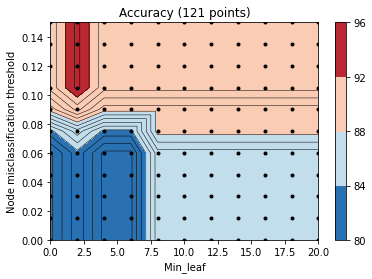

In [ ]:
fig, (ax2) = plt.subplots(nrows=1)
accuracy_ar_hpt=np.zeros((121,3))
count=0
for i in range(11):
    mli=int(i*2/100*x_train_hpt.shape[0])
    for j in range(11):
        cf=j*0.015
        tree_hpt = DecisionTree(max_depth=20,min_leaf_instances=mli,cost_ef=cf)
        probs_test_hpt = tree_hpt.fit(x_train_hpt, y_train_hpt).predict(x_test_hpt)
        y_pred_dt_hpt = np.argmax(probs_test_hpt,1)
        accuracy_ar_hpt[count,:] = [mli,cf,100*np.sum(y_pred_dt_hpt == y_test_hpt)/y_test_hpt.shape[0]]
        count=count+1
    
x=accuracy_ar_hpt[:,0]
y=accuracy_ar_hpt[:,1]
z= accuracy_ar_hpt[:,2]      
ax2.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(x, y, z, levels=2, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(x, y, 'ko', ms=3)
ax2.set(xlim=(0, int(2*10/100*x_train_hpt.shape[0])), ylim=(0, 0.15*1))
ax2.set_title('Accuracy (%d points)' % 121)
plt.xlabel('Min_leaf')
plt.ylabel('Node misclassification threshold')
plt.subplots_adjust(hspace=0.5)
plt.show()

Investigation of accuracy for diabetes with different min_leaf sizes and classification worth rates.

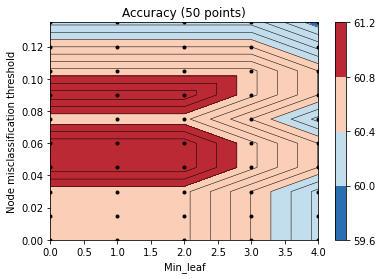

In [ ]:
accuracy_ar_dbt=np.zeros((50,3))
count=0
for i in range(5):
    mli=int(i*1/100*x_train_hpt.shape[0])
    for j in range(10):
        cf=j*0.015
        tree_dbt = DecisionTree(max_depth=20,min_leaf_instances=mli,cost_ef=cf)
        probs_test_dbt = tree_dbt.fit(x_train_dbt, y_train_dbt).predict(x_test_dbt)
        y_pred_dt_dbt = np.argmax(probs_test_dbt,1)
        accuracy_ar_dbt[count,:] = [mli,cf,100*np.sum(y_pred_dt_dbt == y_test_dbt)/y_test_dbt.shape[0]]
        count=count+1

fig, (ax2) = plt.subplots(nrows=1)    
x=accuracy_ar_dbt[:,0]
y=accuracy_ar_dbt[:,1]
z=accuracy_ar_dbt[:,2]      
ax2.tricontour(x, y, z, levels=14, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(x, y, z, levels=2, cmap="RdBu_r")

fig.colorbar(cntr2, ax=ax2)
ax2.plot(x, y, 'ko', ms=3)
ax2.set(xlim=(0, int(1*10/200*x_train_hpt.shape[0])-1), ylim=(0, 0.135))
ax2.set_title('Accuracy (%d points)' % 50)
plt.xlabel('Min_leaf')
plt.ylabel('Node misclassification threshold')
plt.subplots_adjust(hspace=0.5)
plt.show()

Demonstration of classification and relevant decision boundary (hepatitis).

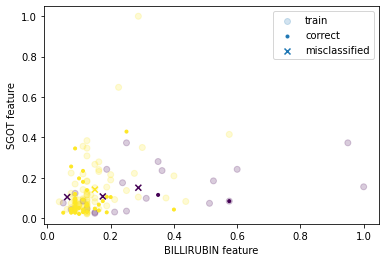

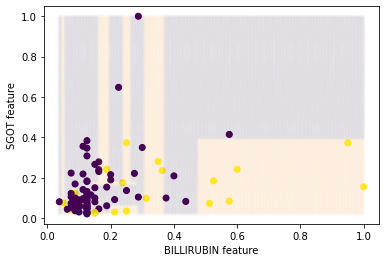

In [ ]:
correct = y_test_hpt == y_pred_dt_hpt
incorrect = np.logical_not(correct)
plt.scatter(x_train_hpt[:,6], x_train_hpt[:,7], c=y_train_hpt, marker='o', alpha=.2, label='train')
plt.scatter(x_test_hpt[correct,6], x_test_hpt[correct,7], marker='.', c=y_pred_dt_hpt[correct], label='correct')
plt.scatter(x_test_hpt[incorrect,6], x_test_hpt[incorrect,7], marker='x', c=y_test_hpt[incorrect], label='misclassified')
plt.xlabel('BILLIRUBIN feature')
plt.ylabel('SGOT feature')
plt.legend()
plt.show()


x0v = np.linspace(np.min(x_hpt[:,6]), np.max(x_hpt[:,6]), 200)
x1v = np.linspace(np.min(x_hpt[:,7]), np.max(x_hpt[:,7]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all_hpt = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(max_depth=200)
y_train_prob_hpt = np.zeros((y_train_hpt.shape[0], 2))
y_train_prob_hpt[np.arange(y_train_hpt.shape[0]), y_train_hpt] = 1
y_prob_all = model.fit(x_train_hpt[:,[6,7]], y_train_hpt).predict(x_all_hpt)
plt.scatter(x_train_hpt[:,6], x_train_hpt[:,7], c=y_train_prob_hpt[:,0], marker='o', alpha=1)
plt.scatter(x_all_hpt[:,0], x_all_hpt[:,1], c=y_prob_all[:,0], marker='.', alpha=.01)
plt.xlabel('BILLIRUBIN feature')
plt.ylabel('SGOT feature')
plt.show()

Demonstration of classification and relevant decision boundary (diabetes).

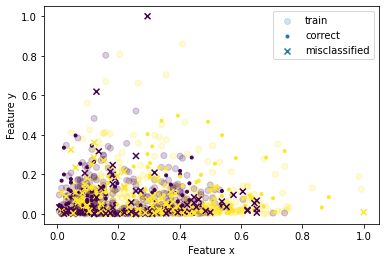

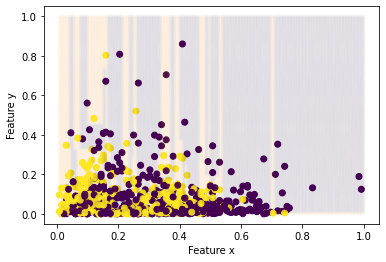

In [ ]:
correct = y_test_dbt == y_pred_dt_dbt
incorrect = np.logical_not(correct)
plt.scatter(x_train_dbt[:,1], x_train_dbt[:,6], c=y_train_dbt, marker='o', alpha=.2, label='train')
plt.scatter(x_test_dbt[correct,1], x_test_dbt[correct,6], marker='.', c=y_pred_dt_dbt[correct], label='correct')
plt.scatter(x_test_dbt[incorrect,1], x_test_dbt[incorrect,6], marker='x', c=y_test_dbt[incorrect], label='misclassified')
plt.legend()
plt.xlabel('Feature x')
plt.ylabel('Feature y')
plt.show()


x0v = np.linspace(np.min(x_dbt[:,1]), np.max(x_dbt[:,1]), 200)
x1v = np.linspace(np.min(x_dbt[:,6]), np.max(x_dbt[:,6]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all_dbt = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(max_depth=200)
y_train_prob_dbt = np.zeros((y_train_dbt.shape[0], 2))
y_train_prob_dbt[np.arange(y_train_dbt.shape[0]), y_train_dbt] = 1
y_prob_all = model.fit(x_train_dbt[:,[1,6]], y_train_dbt).predict(x_all_dbt)
plt.scatter(x_train_dbt[:,1], x_train_dbt[:,6], c=y_train_prob_dbt[:,0], marker='o', alpha=1)
plt.scatter(x_all_dbt[:,0], x_all_dbt[:,1], c=y_prob_all[:,0], marker='.', alpha=.01)
plt.xlabel('Feature x')
plt.ylabel('Feature y')
plt.show()

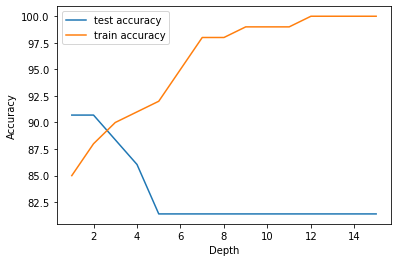

In [ ]:
accuracy_ar_hpt=np.zeros((15,2))
accuracy_ar_hpt_tr=np.zeros((15,2))
for i in range(15):
        tree_hpt = DecisionTree(max_depth=i+1,min_leaf_instances=1,cost_ef=0)
        probs_test_hpt = tree_hpt.fit(x_train_hpt, y_train_hpt).predict(x_test_hpt)
        y_pred_dt_hpt = np.argmax(probs_test_hpt,1)
        probs_test_hpt_tr = tree_hpt.fit(x_train_hpt, y_train_hpt).predict(x_train_hpt)
        y_pred_dt_hpt_tr = np.argmax(probs_test_hpt_tr,1)
        accuracy_ar_hpt[i,:] =[i+1,100*np.sum(y_pred_dt_hpt == y_test_hpt)/y_test_hpt.shape[0]]
        accuracy_ar_hpt_tr[i,:] =[i+1,100*np.sum(y_pred_dt_hpt_tr == y_train_hpt)/y_train_hpt.shape[0]] 
plt.plot(accuracy_ar_hpt[:,0],accuracy_ar_hpt[:,1],label='test accuracy')
plt.plot(accuracy_ar_hpt_tr[:,0],accuracy_ar_hpt_tr[:,1],label='train accuracy')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()

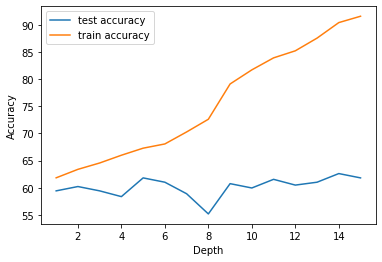

In [ ]:
accuracy_ar_dbt=np.zeros((15,2))
accuracy_ar_dbt_tr=np.zeros((15,2))
for i in range(15):
        tree_dbt = DecisionTree(max_depth=i+1,min_leaf_instances=1,cost_ef=0)
        probs_test_dbt_tr = tree_dbt.fit(x_train_dbt, y_train_dbt).predict(x_train_dbt)
        y_pred_dt_dbt_tr = np.argmax(probs_test_dbt_tr,1)
        probs_test_dbt = tree_dbt.fit(x_train_dbt, y_train_dbt).predict(x_test_dbt)
        y_pred_dt_dbt = np.argmax(probs_test_dbt,1)
        accuracy_ar_dbt[i,:] =[i+1,100*np.sum(y_pred_dt_dbt == y_test_dbt)/y_test_dbt.shape[0]] 
        accuracy_ar_dbt_tr[i,:] =[i+1,100*np.sum(y_pred_dt_dbt_tr == y_train_dbt)/y_train_dbt.shape[0]] 
plt.plot(accuracy_ar_dbt[:,0],accuracy_ar_dbt[:,1],label='test accuracy')
plt.plot(accuracy_ar_dbt_tr[:,0],accuracy_ar_dbt_tr[:,1],label='train accuracy')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()